In [55]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Load the data
with open("log_LOAD.txt", "r") as f:
    data = f.readlines()
    columns = data[0].strip().split(', ')
    data = data[2:]

    df = pd.DataFrame([x.strip().split(', ') for x in data], columns=columns)
    
df.head()

,Position,Velocity,Time,Started
0,8,5026.18994140625,2998,0
1,13,5026.18994140625,2999,0
2,18,5026.18994140625,3000,0
3,23,5026.18994140625,3001,0
4,28,5026.18994140625,3002,0


In [56]:
with open("logEncoder_LOAD.txt", "r") as f:
    data = f.readlines()
    columns = data[0].strip().split(', ')
    data = data[1:]

    dfEncoder = pd.DataFrame([x.strip().split(', ') for x in data], columns=columns)

dfEncoder.head()

,Raw Angle,Time,Match Flag,Started
0,1788,1282,1,0
1,1795,1283,1,0
2,1810,1284,1,0
3,1803,1285,1,0
4,1774,1286,1,0


In [57]:
# Convert the data to the correct types
df['Position'] = df['Position'].astype(int)
df['Velocity'] = df['Velocity'].astype(float)
df['Time'] = df['Time'].astype(int)
df['Started'] = df['Started'].astype(int)

In [58]:
# Convert the data to the correct types
dfEncoder['Raw Angle'] = dfEncoder['Raw Angle'].astype(int)
dfEncoder['Time'] = dfEncoder['Time'].astype(int)
dfEncoder['Match Flag'] = dfEncoder['Match Flag'].astype(int)
dfEncoder['Started'] = dfEncoder['Started'].astype(int)

In [59]:
# Reset Time to start at 0
df['Time'] = df['Time'] - df['Time'].min()
dfEncoder['Time'] = dfEncoder['Time'] - dfEncoder['Time'].min()

In [60]:
df['Time'] = df['Time'] / 1000
dfEncoder['Time'] = dfEncoder['Time'] / 1000

In [61]:
spr = 1600

df['Angle'] = df['Position'].apply(lambda x: x * 360 / spr)
df['Radian'] = df['Angle'].apply(lambda x: x * 3.14159 / 180)
df['Velocity'] = df['Velocity'] * (2 * np.pi) / spr

In [62]:
df['Acceleration'] = df['Velocity'].diff() / df['Time'].diff()
df['Acceleration'] = df['Acceleration'].fillna(0)

df.head()

,Position,Velocity,Time,Started,Angle,Radian,Acceleration
0,8,19.737802,0.000,0,1.800,0.031416,0.0
1,13,19.737802,0.001,0,2.925,0.051051,0.0
2,18,19.737802,0.002,0,4.050,0.070686,0.0
3,23,19.737802,0.003,0,5.175,0.090321,0.0
4,28,19.737802,0.004,0,6.300,0.109956,0.0


<Axes: title={'center': 'Raw Angle vs Time'}, xlabel='Time'>

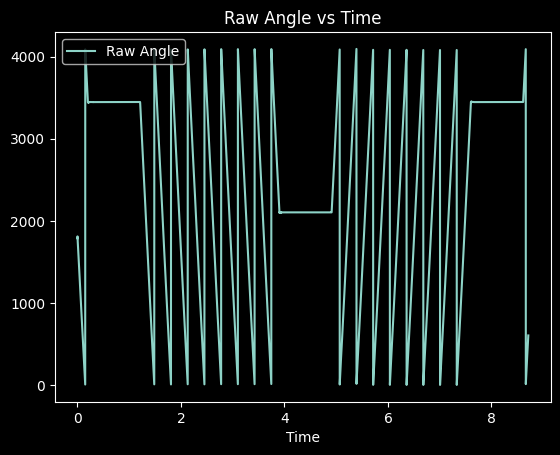

In [63]:
dfEncoder.plot(x='Time', y='Raw Angle', title='Raw Angle vs Time')

<Axes: title={'center': 'Angle vs Time'}, xlabel='Time'>

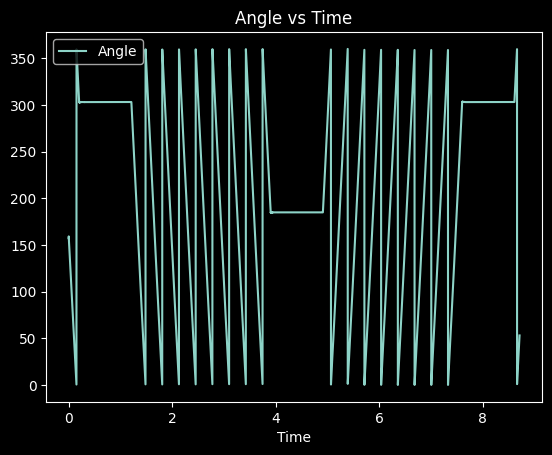

In [64]:
# Map raw angle (0-4095) to degrees (0-360)
dfEncoder['Angle'] = dfEncoder['Raw Angle'] / 4095 * 360

dfEncoder.plot(x='Time', y='Angle', title='Angle vs Time')

<Axes: title={'center': 'Angle vs Time'}, xlabel='Time'>

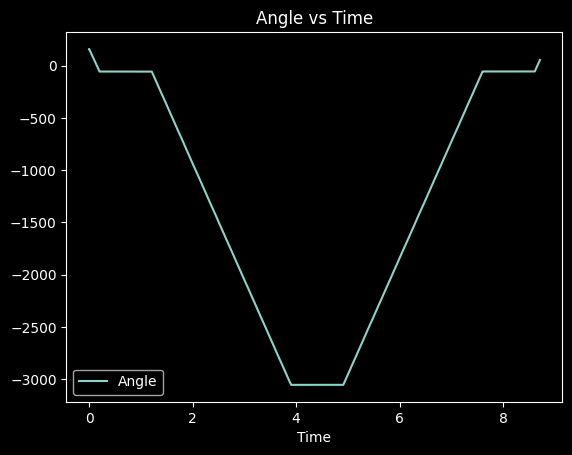

In [65]:
# Continuous angle
continuous_angle = [dfEncoder['Angle'].iloc[0]]

# Calculate into continuous angle
for i in range(1, len(dfEncoder)):
    delta_angle = dfEncoder['Angle'][i] - dfEncoder['Angle'][i - 1]
    if delta_angle > 180:
        delta_angle -= 360
    elif delta_angle < -180:
        delta_angle += 360

    continuous_angle.append(continuous_angle[-1] + delta_angle)

dfEncoder['Angle'] = continuous_angle

dfEncoder.plot(x='Time', y='Angle', title='Angle vs Time')

<Axes: title={'center': 'Angle vs Time'}, xlabel='Time'>

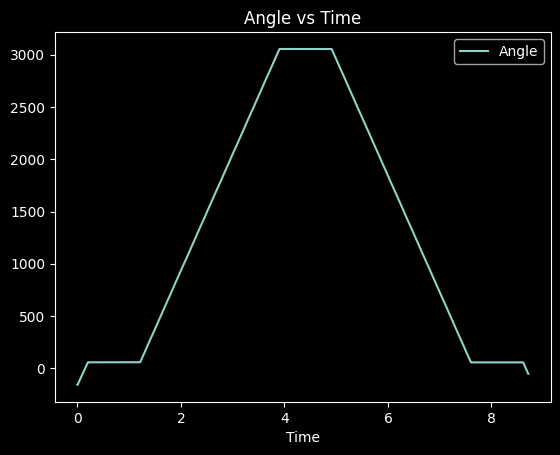

In [66]:
# Change direction of angle
dfEncoder['Angle'] = -dfEncoder['Angle']

dfEncoder.plot(x='Time', y='Angle', title='Angle vs Time')

In [67]:
dfEncoder['Radian'] = np.deg2rad(dfEncoder['Angle'])
dfEncoder['Velocity'] = dfEncoder['Radian'].diff() / dfEncoder['Time'].diff()
dfEncoder['Velocity'] = dfEncoder['Velocity'].fillna(0)

dfEncoder['Acceleration'] = dfEncoder['Velocity'].diff() / dfEncoder['Time'].diff()
dfEncoder['Acceleration'] = dfEncoder['Acceleration'].fillna(0)

dfEncoder.head()

,Raw Angle,Time,Match Flag,Started,Angle,Radian,Velocity,Acceleration
0,1788,0.000,1,0,-157.186813,-2.743427,0.000000,0.000000
1,1795,0.001,1,0,-157.802198,-2.754168,-10.740488,-10740.487705
2,1810,0.002,1,0,-159.120879,-2.777183,-23.015331,-12274.843091
3,1803,0.003,1,0,-158.505495,-2.766443,10.740488,33755.818500
4,1774,0.004,1,0,-155.956044,-2.721946,44.496306,33755.818500


In [68]:
columnsDF = ['Position', 'Angle', 'Radian', 'Velocity', 'Acceleration', 'Started', 'Time']
columnsDFEncoder = ['Raw Angle', 'Angle', 'Radian', 'Velocity', 'Acceleration', 'Match Flag', 'Started', 'Time']

df = df[columnsDF]
dfEncoder = dfEncoder[columnsDFEncoder]

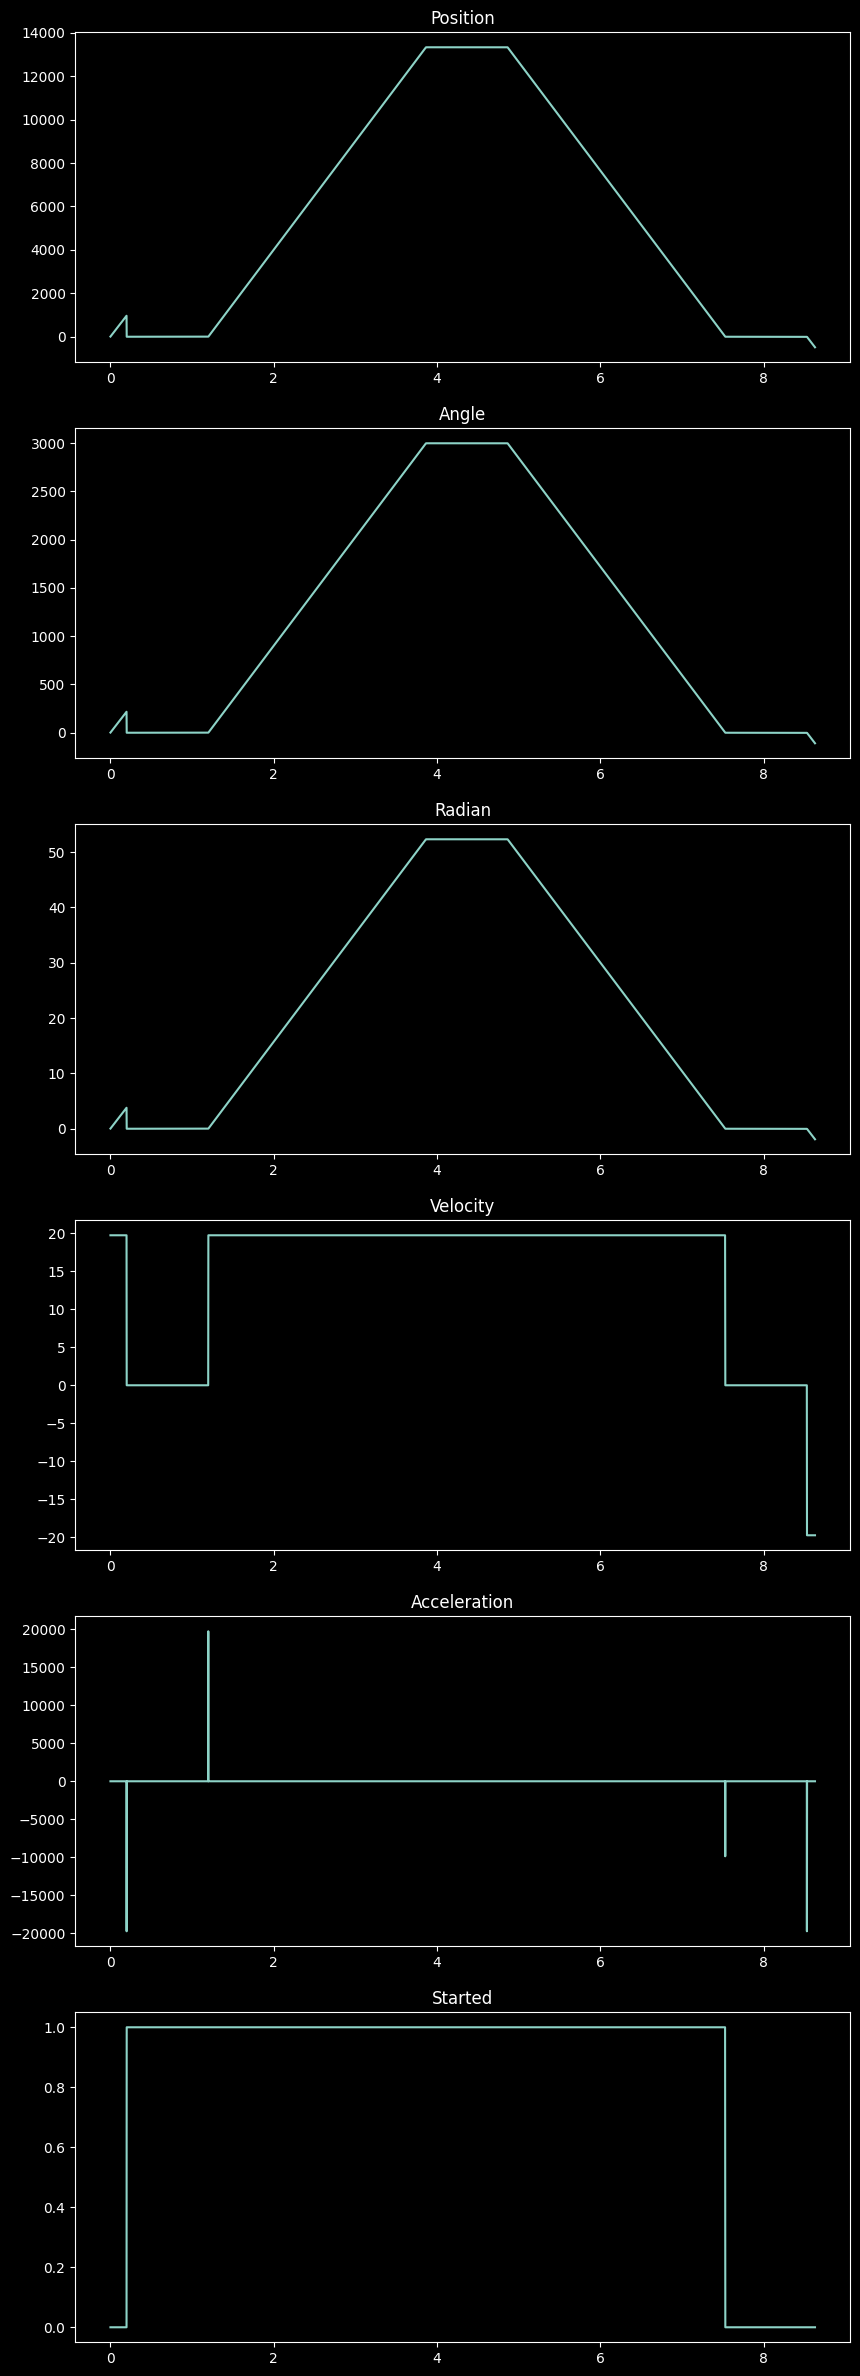

In [69]:
fig, ax = plt.subplots(len(columnsDF) - 1, 1, figsize=(10, 30))
for i, col in enumerate(columnsDF[:-1]):
    ax[i].plot(df['Time'], df[col])
    ax[i].set_title(col)

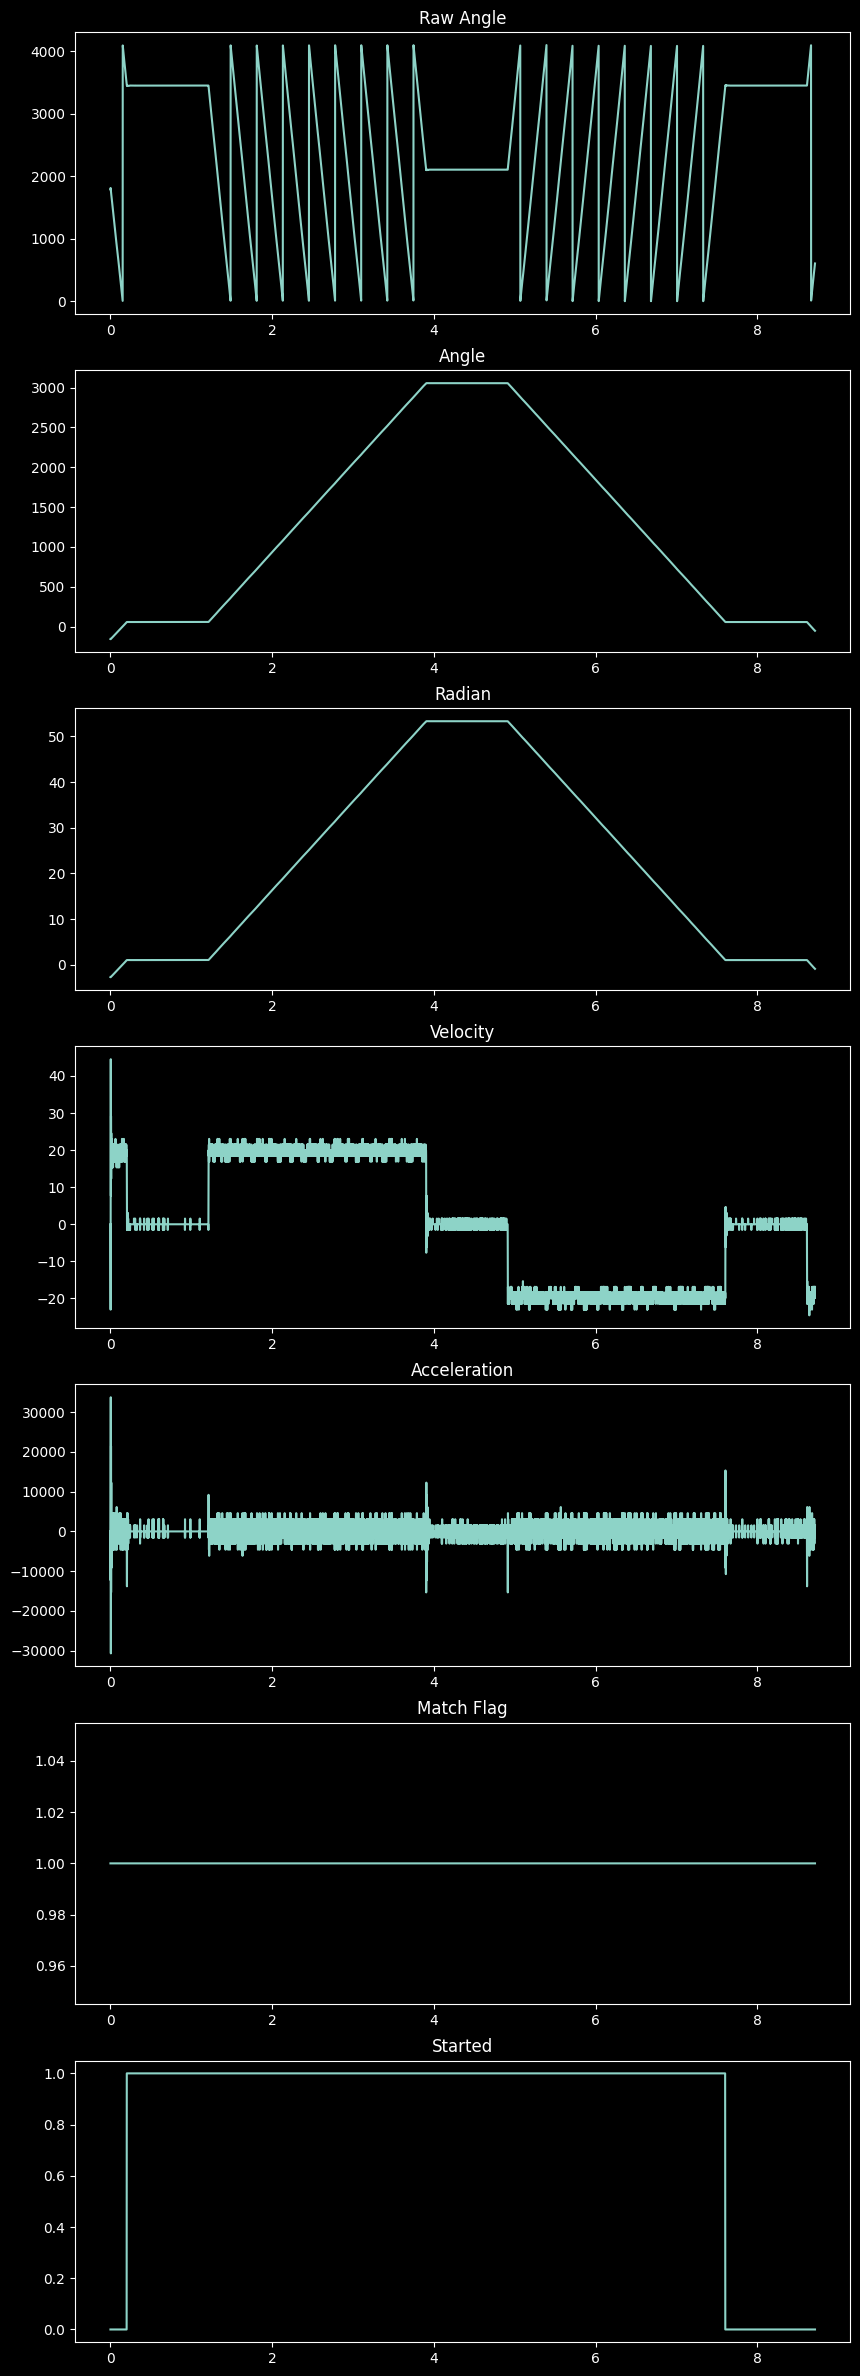

In [70]:
fig, ax = plt.subplots(len(columnsDFEncoder) - 1, 1, figsize=(10, 30))
for i, col in enumerate(columnsDFEncoder[:-1]):
    ax[i].plot(dfEncoder['Time'], dfEncoder[col])
    ax[i].set_title(col)

In [71]:
dfCopy = dfEncoder.copy()
dfCopy['Time'] = dfCopy['Time'] - dfCopy['Time'].min()

# Calculate angular velocity
dfCopy['Velocity'] = dfCopy['Radian'].diff() / dfCopy['Time'].diff()
dfCopy['Velocity'] = dfCopy['Velocity'].fillna(0)

# Apply low pass filter
dfCopy['Velocity Filtered'] = dfCopy['Velocity'].rolling(window=30).mean()

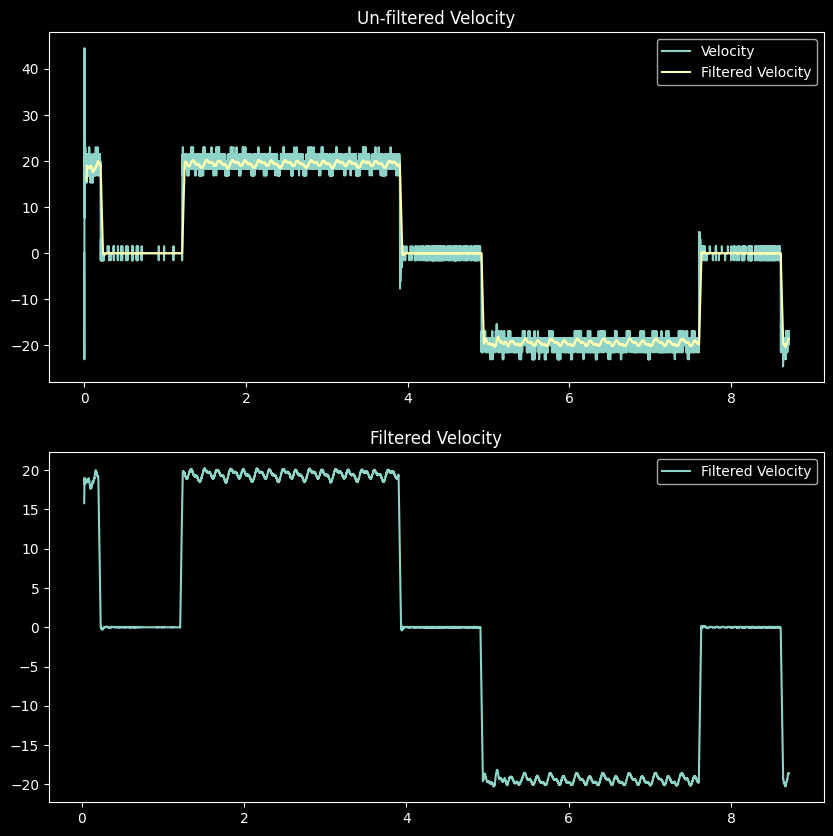

In [72]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(dfCopy['Time'], dfCopy['Velocity'])
ax[0].plot(dfCopy['Time'], dfCopy['Velocity Filtered'])
ax[1].plot(dfCopy['Time'], dfCopy['Velocity Filtered'])

ax[0].set_title('Un-filtered Velocity')
ax[1].set_title('Filtered Velocity')

ax[0].legend(['Velocity', 'Filtered Velocity'])
ax[1].legend(['Filtered Velocity'])